# Import files, libraries, define path and initialize lists

In [ ]:
!pip install kagglehub
from google.colab import files

import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.70G/2.70G [02:06<00:00, 22.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image
import glob
import os
import shutil
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint

Mounted at /content/drive


In [ ]:
# Define the dataset path
root_folder = "/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2"

data_dir = os.path.join(root_folder, 'new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/')

test_path = os.path.join(root_folder, 'test/test')
train_path = os.path.join(data_dir, 'train')
valid_path = os.path.join(data_dir, 'valid')

In [ ]:
# Initialize lists
image_paths = []
species_labels = []
disease_labels = []
dataset_split = []

# Function to process a dataset directory
def process_directory(base_path, split_name):
    for class_folder in os.listdir(base_path):
        class_folder_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_folder_path):
            species, disease = class_folder.split('___')
            for image_name in os.listdir(class_folder_path):
                image_paths.append(os.path.join(class_folder_path, image_name))
                species_labels.append(species)
                disease_labels.append(disease)
                dataset_split.append(split_name)

# Process train and valid
process_directory(train_path, 'train')
process_directory(valid_path, 'valid')

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'species': species_labels,
    'disease': disease_labels,
    'split': dataset_split
})

# Model Training

In [ ]:
import keras
keras.backend.clear_session()

#Define model name
Model_name = 'LLC_VGG16_unfrozenlowerLR_v1'

In [ ]:
# Define the image generators for the training and validation set
batch_size = 32
num_classes = 38
img_size = (256, 256)

train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
# Import the VGG16 model as a baseline
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Unfreeze the base model layers
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers for classification
model_vgg16 = Sequential()
model_vgg16.add(base_model)
model_vgg16.add(GlobalAveragePooling2D())
model_vgg16.add(Dense(1024, activation="relu"))
model_vgg16.add(Dropout(rate=0.2))
model_vgg16.add(Dense(512, activation="relu"))
model_vgg16.add(Dropout(rate=0.2))
model_vgg16.add(Dense(num_classes, activation="softmax"))

# Compile the model
optimizer = Adam(learning_rate = 0.0001)  # Lower learning rate
model_vgg16.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Define callbacks
epoch_checkpoint = ModelCheckpoint(
    'model_epoch_{epoch:02d}.keras',  # Filename to save the model, it will save with the epoch number
    save_weights_only=False,       # Save the entire model (including architecture, optimizer, and weights)
    save_freq='epoch',             # Save the model after every epoch
    verbose=1                      # Print a message when saving the model
)
best_model = ModelCheckpoint(
    f"{Model_name}.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [
    epoch_checkpoint,
    best_model
]

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Training the model
model_vgg16.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    callbacks = callbacks
    )

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4554 - loss: 1.8788
Epoch 1: saving model to model_epoch_01.keras

Epoch 1: val_accuracy improved from -inf to 0.92585, saving model to LLC_VGG16_unfrozenlowerLR_v1.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 247s 98ms/step - accuracy: 0.4555 - loss: 1.8784 - val_accuracy: 0.9258 - val_loss: 0.2199
Epoch 2/50
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9352 - loss: 0.2029
Epoch 2: saving model to model_epoch_02.keras

Epoch 2: val_accuracy improved from 0.92585 to 0.95094, saving model to LLC_VGG16_unfrozenlowerLR_v1.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 182s 82ms/step - accuracy: 0.9352 - loss: 0.2028 - val_accuracy: 0.9509 - val_loss: 0.1469
Epoch 3/50
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9645 - loss: 0.1133
Epoch 3: saving model to model_epoch_03.keras

Epoch 3: val_accuracy improved from 0.95094 to 0.96603, saving model to LLC_VGG16_unfrozenlowerLR_v1.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 182s 82ms/

Save model

In [ ]:
# Create the DS_Models folder if it doesn't exist
model_folder = '/content/drive/MyDrive/DS_models'
os.makedirs(model_folder, exist_ok=True)

# Define the model save path
model_save_path = os.path.join(model_folder, 'LLC_VGG16_unfrozenlowerLR_v1.keras')

# Define the path to the model in Colab and the Google Drive save path
colab_model_path = '/content/LLC_VGG16_unfrozenlowerLR_v1.keras'  # Adjust if it's located elsewhere in your Colab environment
model_save_path = os.path.join(model_folder, 'LLC_VGG16_unfrozenlowerLR_v1.keras')

# Copy the model to Google Drive
!cp {colab_model_path} {model_save_path}

# Confirm the model is saved in Google Drive
!ls /content/drive/MyDrive/DS_models/

save_dir = model_folder

best_model_epoch_07.keras		  LLC_VGG16_1Block_unfrozen_v1_old.keras
best_VGG16_model_epoch_7.keras		  LLC_VGG16_1Block_unfrozen_v1_predictions.csv
best_VGG16_unfrozen_model_epoch_6.keras   LLC_VGG16_unfrozenlowerLR_v1.keras
LLC_MobileNetV2_1Block_unfrozen_v1.keras  LLC_VGG16_unfrozen_v1.keras
LLC_MobileNetV2_unfrozen_v1.keras	  LLC_VGG16_unfrozen_v1_predictions.csv
LLC_VGG16_1Block_unfrozen_v1.keras	  model_epoch_02.keras


In [ ]:
save_dir = "/content/drive/MyDrive/DS_models"
model_vgg16.save(f"{save_dir}/LLC_VGG16_unfrozen_v1.keras")

Plot Metrics

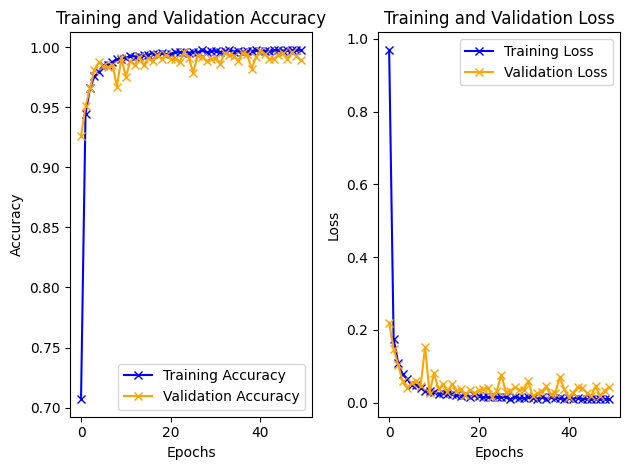

In [ ]:
# Plot metrics history

history = model_vgg16.history

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', marker='x')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='x')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

Prediction and classification report

In [ ]:
# Generate predictions for validation set
val_pred = model_vgg16.predict(validation_generator)
val_pred_classes = np.argmax(val_pred, axis=1)
true_classes = validation_generator.classes

# Classification report
class_report = classification_report(true_classes, val_pred_classes)
print("Classification Report:\n", class_report)

550/550 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.03      0.03      0.03       504
           1       0.03      0.03      0.03       497
           2       0.02      0.02      0.02       440
           3       0.04      0.04      0.04       502
           4       0.03      0.03      0.03       454
           5       0.01      0.01      0.01       421
           6       0.03      0.03      0.03       456
           7       0.01      0.01      0.01       410
           8       0.02      0.02      0.02       477
           9       0.04      0.04      0.04       477
          10       0.03      0.03      0.03       465
          11       0.03      0.03      0.03       472
          12       0.02      0.02      0.02       480
          13       0.02      0.02      0.02       430
          14       0.03      0.03      0.03       423
          15       0.02      0.02      0.02       503
          16  

In [ ]:
# Step 1: Evaluate the model on the validation set
loss, accuracy = model_vgg16.evaluate(validation_generator)




550/550 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.9890 - loss: 0.0451


In [ ]:
# Step 2: Print the accuracy
print(f'Validation loss: {loss:.2f}')
print(f'Validation accuracy: {accuracy:.2f}')

Validation loss: 0.04
Validation accuracy: 0.99


Evaluate the test folder

In [ ]:
# Define helper function to preprocess a single image
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)  # Load image and resize
    img_array = img_to_array(img) / 255.0               # Convert to array and rescale
    return img_array

# Load and preprocess all images from the test folder
def load_test_images(test_path, target_size):
    test_images = []
    filenames = []
    for file in os.listdir(test_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Supported file formats
            file_path = os.path.join(test_path, file)
            test_images.append(preprocess_image(file_path, target_size))
            filenames.append(file)  # Save filenames for reference
    return np.array(test_images), filenames

# Function to check if prediction is correct based on common words
def is_prediction_correct(file_name, predicted_label):
    # Extract meaningful words from file name (split camel case or concatenated words)
    file_name = re.sub(r'\.\w+$', '', file_name)  # Remove file extension
    file_words = set(word.lower() for word in re.findall(r'[A-Z][a-z]*|[a-z]+', file_name))  # Handle camel case and lowercase

    # Extract meaningful words from predicted label
    label_words = set(word.lower() for word in re.findall(r'[A-Za-z]+', predicted_label))  # Convert to lowercase

    # Check if all file words are in the label words
    is_subset = file_words.issubset(label_words)

    # Debugging output to verify
    #print(f"File Words: {file_words}, Label Words: {label_words}, Is Subset: {is_subset}")

    return is_subset

# Parameters
IMG_SIZE = (256, 256)  # Adjust to model's input size
test_path = test_path  # Define the test folder path

# Load and preprocess test images
test_images, filenames = load_test_images(test_path, target_size=IMG_SIZE)

# Make Predictions
predictions = model_vgg16.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Map predictions to class labels
class_labels = train_generator.class_indices
class_indices = {v: k for k, v in class_labels.items()}  # Reverse mapping of class indices
predicted_labels = [class_indices[idx] for idx in predicted_classes]

# Process and evaluate predictions
results = []

for file, pred, label in zip(filenames, predictions, predicted_labels):
    confidence = np.max(pred)  # Get the highest probability (confidence score)
    is_correct = is_prediction_correct(file, label)  # Check prediction correctness
    results.append({"True class": file, "prediction": label, "confidence": confidence, "Correct": int(is_correct)})
    print(f"True class: {file}, Prediction: {label}, Confidence: {confidence:.2f}, Correct: {is_correct}")

# Summary of results
correct_predictions = sum(result['Correct'] for result in results)
total_predictions = len(results)
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
print(f"Total Predictions: {total_predictions}, Correct: {correct_predictions}, Accuracy: {accuracy:.2%}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
True class: PotatoEarlyBlight2.JPG, Prediction: Potato___Early_blight, Confidence: 1.00, Correct: True
True class: AppleScab1.JPG, Prediction: Apple___Apple_scab, Confidence: 1.00, Correct: True
True class: TomatoHealthy3.JPG, Prediction: Tomato___healthy, Confidence: 1.00, Correct: True
True class: PotatoEarlyBlight1.JPG, Prediction: Potato___Early_blight, Confidence: 1.00, Correct: True
True class: AppleCedarRust3.JPG, Prediction: Apple___Cedar_apple_rust, Confidence: 1.00, Correct: True
True class: AppleScab3.JPG, Prediction: Apple___Apple_scab, Confidence: 1.00, Correct: True
True class: AppleScab2.JPG, Prediction: Apple___Apple_scab, Confidence: 1.00, Correct: True
True class: TomatoYellowCurlVirus3.JPG, Prediction: Tomato___Tomato_Yellow_Leaf_Curl_Virus, Confidence: 1.00, Correct: True
True class: CornCommonRust1.JPG, Prediction: Corn_(maize)___Common_rust_, Confidence: 1.00, Correct: True
True class: TomatoHealthy1.JPG, Prediction: Tomato___he

In [ ]:
# Define helper function to preprocess a single image
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)  # Load image and resize
    img_array = img_to_array(img) / 255.0               # Convert to array and rescale
    return img_array

# Load and preprocess all images from the test folder
def load_test_images(test_path, target_size):
    test_images = []
    filenames = []
    for file in os.listdir(test_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Supported file formats
            file_path = os.path.join(test_path, file)
            test_images.append(preprocess_image(file_path, target_size))
            filenames.append(file)  # Save filenames for reference
    return np.array(test_images), filenames

# Parameters
IMG_SIZE = (256, 256)  # Adjust to model's input size
test_path = test_path

# Load and preprocess test images
test_images, filenames = load_test_images(test_path, target_size=IMG_SIZE)

# Make Predictions
predictions = model_vgg16.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Map predictions to class labels
class_labels = train_generator.class_indices
class_indices = {v: k for k, v in class_labels.items()}  # Reverse mapping of class indices
predicted_labels = [class_indices[idx] for idx in predicted_classes]

# Print predictions with filenames
results = []

for file, pred, label in zip(filenames, predictions, predicted_labels):
    confidence = np.max(pred)  # Get the highest probability (confidence score)
    print(f"True class:{file}, Predictions:{label} (Confidence: {confidence:.2f})")

    # Pause and ask for feedback
    feedback = input("Is the prediction correct? (1 for Yes, 0 for No): ")
    if feedback == "1":
        results.append({"file": file, "prediction": label, "confidence": confidence, "Correct": "1"})
    else:
        results.append({"file": file, "prediction": label, "confidence": confidence, "Correct": "0"})

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
True class:PotatoEarlyBlight2.JPG, Predictions:Potato___Early_blight (Confidence: 1.00)
Is the prediction correct? (1 for Yes, 0 for No): 1
True class:AppleScab1.JPG, Predictions:Apple___Apple_scab (Confidence: 1.00)
Is the prediction correct? (1 for Yes, 0 for No): 1
True class:TomatoHealthy3.JPG, Predictions:Tomato___healthy (Confidence: 1.00)
Is the prediction correct? (1 for Yes, 0 for No): 1
True class:PotatoEarlyBlight1.JPG, Predictions:Potato___Early_blight (Confidence: 1.00)
Is the prediction correct? (1 for Yes, 0 for No): 1
True class:AppleCedarRust3.JPG, Predictions:Apple___Cedar_apple_rust (Confidence: 1.00)
Is the prediction correct? (1 for Yes, 0 for No): 1
True class:AppleScab3.JPG, Predictions:Apple___Apple_scab (Confidence: 1.00)
Is the prediction correct? (1 for Yes, 0 for No): 1
True class:AppleScab2.JPG, Predictions:Apple___Apple_scab (Confidence: 1.00)
Is the prediction correct? (1 for Yes, 0 for No): 1
True class:TomatoYellowC

Create DataFrame and save as CSV in google drive

In [ ]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Print the DataFrame
print("\nSummary of Predictions and Feedback:")
display(df_results)

# Save DataFrame to CSV
output_csv_path = f"{save_dir}/{Model_name}_predictions.csv"  # Specify the output file path
df_results.to_csv(output_csv_path, index=False)

print(f"Predictions have been saved to {output_csv_path}")


Summary of Predictions and Feedback:


,file,prediction,confidence,Correct
0,PotatoEarlyBlight2.JPG,Potato___Early_blight,1.000000,1
1,AppleScab1.JPG,Apple___Apple_scab,1.000000,1
2,TomatoHealthy3.JPG,Tomato___healthy,1.000000,1
3,PotatoEarlyBlight1.JPG,Potato___Early_blight,1.000000,1
4,AppleCedarRust3.JPG,Apple___Cedar_apple_rust,1.000000,1
5,AppleScab3.JPG,Apple___Apple_scab,1.000000,1
6,AppleScab2.JPG,Apple___Apple_scab,1.000000,1
7,TomatoYellowCurlVirus3.JPG,Tomato___Tomato_Yellow_Leaf_Curl_Virus,1.000000,1
8,CornCommonRust1.JPG,Corn_(maize)___Common_rust_,1.000000,1
9,TomatoHealthy1.JPG,Tomato___healthy,1.000000,1


NameError: name 'save_dir' is not defined

prediction accuracy

In [ ]:
df_results["Correct"].value_counts(normalize=True)


,proportion
Correct,
0,0.909091
1,0.090909
